In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

%matplotlib inline

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cyl_map = [
        ['si', 5.431, [14, 14]],
        ['ge', 5.658, [32, 32]],
        ['sige', 5.432, [14, 32]],
        ['sn', 6.4892, [50, 50]],
        ['snsi', 5.961, [14, 50]],
        ['gesn', 6.0758, [32, 50]],
        ['gaas', 5.6535, [31, 33]],
        ['alp', 5.4635, [13, 15]],
        ['alas', 5.660, [13, 33]],
        ['alsb', 6.1355, [13, 51]],
        ['gap', 5.451, [31, 15]],
        ['gasb', 6.09, [31, 51]],
        ['inp', 5.86, [49, 15]],
        ['inas', 6.05, [49, 33]],
        ['insb', 6.47, [49, 51]],

]

# Gradiant vector and Hessian matrix construction

In [3]:
H_dict = {}
G_dict = {}
a_ref_dict = {}
qmouts = {}
for info_cyl in cyl_map:
    base = info_cyl[0]
    H_root = '%s_H_scan' % base
    delta = 0.01
    H_list = []
    G_list = []
    outs = []
    a_ref_list = []
    H_dict[base] = H_list
    G_dict[base] = G_list
    a_ref_dict[base] = a_ref_list
    qmouts[base] = outs
    for info_a in cyl_map:
        tar = info_a[0]
        N = len(sorted(glob('%s/%s_a-%s_i??[pm]-I*' % (H_root, base, tar)))) / 2
        H = np.zeros([N, N])
        G = np.zeros(N)
        H_list.append(H)
        G_list.append(G)

        a_ref_file = glob("%s/%s_a-%s/*.out" % (H_root, base, tar))[0]
        a_ref = qtk.QMOut(a_ref_file, program='cpmd')
        a_ref_list.append(a_ref)
        outs.append(a_ref)

        di_p = []
        di_m = []
        for i in range(N):
            di_p_file = glob('%s/%s_a-%s_i%02dp-I*/*.out' % (H_root, base, tar, i))[0]
            di_m_file = glob('%s/%s_a-%s_i%02dm-I*/*.out' % (H_root, base, tar, i))[0]
    #         di_p_file = glob('%s/%s_a-%s_i%03dp-I*/*.out' % (H_root, base, tar, i))[0]
    #         di_m_file = glob('%s/%s_a-%s_i%03dm-I*/*.out' % (H_root, base, tar, i))[0]
            dp = qtk.QMOut(di_p_file, program='cpmd')
            dm = qtk.QMOut(di_m_file, program='cpmd')
            di_p.append(dp)
            di_m.append(dm)
            outs.append(dp)
            outs.append(dm)
            H[i, i] = (dp + dm - 2*a_ref) / (delta)**2
            G[i] = (dp - dm) / (2*delta)

        for i in range(N):
            for j in range(i+1, N):
                didj_file = glob('%s/%s_a-%s_i%02dj%02d*/*.out' % (H_root, base, tar, i, j))[0]
                #didj_file = glob('%s/%s_a-%s_i%03dj%03d*/*.out' % (H_root, base, tar, i, j))[0]
                didj = qtk.QMOut(didj_file, program='cpmd')
                outs.append(didj)

                H[i, j] = (((didj - di_p[j]) / delta) - ((di_p[i] - a_ref) / delta)) / delta
                H[j, i] = H[i, j]        

    print len(H_list)

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15


In [4]:
H_dict['ge'][0].shape

(30, 30)

# Prediction test

In [5]:
ref_dir = 'ref'
outs_all = []
for info_a in cyl_map:
    outs = [info_a[0], []]
    outs_all.append(outs)
    for info_cyl in cyl_map:
        cyl = info_cyl[0]
        tar = info_a[0]
        out_file = glob('%s/%s_a-%s/*.out' % (ref_dir, cyl, tar))[0]
        out = qtk.QMOut(out_file, program='cpmd')
        #outs[1].append([out.name.split('.')[0], out])
        outs[1].append(out)

In [6]:
mol_base = qtk.Molecule('xyz/ge.xyz')

In [7]:
def cyl2par(mol, size=[1, 3]):
    mol.sort(order='xyz')
    par = []
    for a in mol.type_list:
        crd = qtk.PP(a, size=size)
        vec = crd.vectorize()
        par.append([vec[0][1:], a, vec[0][0]])
    return par

def par2cyl(par, mol_base=mol_base, size=[1, 3]):
    mol = mol_base.copy()
    mol.sort(order='xyz')
    for i, crd in enumerate(par):
        print crd
        pp = qtk.PP(crd[1], size=size)
        vec = [crd[2]]
        vec.extend(crd[0])
        pp.unvectorize(vec, size[0], range(size[1], 0, -1))
        pp.name = crd[1] + '%02d' % i
        mol.setAtoms(i, string=pp)
    return mol

def mol2vec(mol_tar, mol_ref, size=[1, 3]):
    par_tar = cyl2par(mol_tar)
    par_ref = cyl2par(mol_ref)
    vec_tar = np.hstack([p[0] for p in par_tar])
    vec_ref = np.hstack([p[0] for p in par_ref])
    return vec_tar - vec_ref

In [8]:
tars_dict = {}
prd_1_dict = {}
prd_2_dict = {}

for cyl, G_list in G_dict.iteritems():
    tars = []
    prd_1 = []
    prd_2 = []
    tars_dict[cyl] = tars
    prd_1_dict[cyl] = prd_1
    prd_2_dict[cyl] = prd_2
    for a_pos in range(len(a_ref_dict[cyl])):
        ref = a_ref_dict[cyl][a_pos]
        for tar in outs_all[a_pos][1]:
            vec = mol2vec(tar.molecule, ref.molecule)
            try:
                dE1 = G_dict[cyl][a_pos].dot(vec)
                dE2 = vec.dot(H_dict[cyl][a_pos].dot(vec)) / 2
                # only compute predictions to other crystals
                if sum(abs(vec)) > 0:
                    tars.append(tar.Et)
                    prd_1.append(ref.Et + dE1)
                    prd_2.append(ref.Et + dE1 + dE2)
            except ValueError:
                print "failed: ", cyl, i, G_dict[cyl][a_pos].shape

In [9]:
tars_dict.keys()


['gaas',
 'insb',
 'gesn',
 'sige',
 'gasb',
 'inp',
 'si',
 'snsi',
 'ge',
 'alas',
 'sn',
 'gap',
 'alsb',
 'inas',
 'alp']

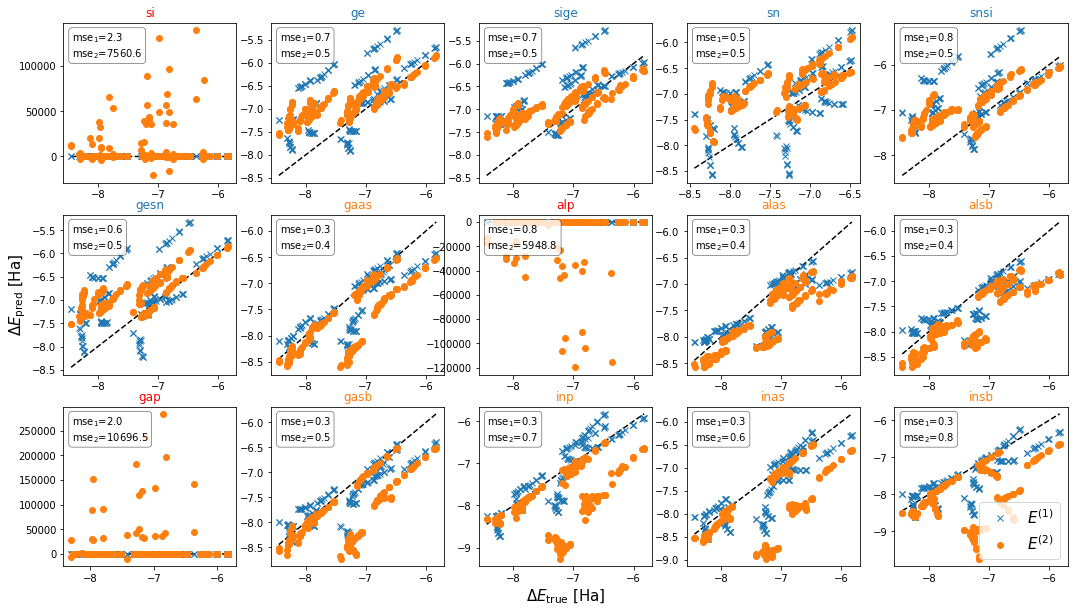

In [44]:
fig, axs = plt.subplots(3, 5, figsize=(18,10))
ax_last = None
bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=.5, alpha=0.8)
for i, info_cyl in enumerate(cyl_map):
    cyl = info_cyl[0]
    row, col = divmod(i, 5)
    ax = axs[row][col]
    try:
        tars = tars_dict[cyl]
        prd_1 = prd_1_dict[cyl]
        prd_2 = prd_2_dict[cyl]    
        tar_min, tar_max = min(tars), max(tars)
        ax.plot([tar_min, tar_max], [tar_min, tar_max], ls='--', color='k')
        ax.plot(tars, prd_1, ls='', marker='x', label='$E^{(1)}$')
        ax.plot(tars, prd_2, ls='', marker='o', label='$E^{(2)}$')
        ax_last = ax
        
        y_min, y_max = ax.get_ylim()
        x_min, x_max = ax.get_xlim()
        x_text = x_min + 0.05 * (x_max - x_min)
        y_text = y_min + 0.95 * (y_max - y_min)
        mse_1 = abs(np.array(tars) - np.array(prd_1)).mean()
        mse_2 = abs(np.array(tars) - np.array(prd_2)).mean()
        ax.text(x_text, y_text, 
                "mse$_1$=%1.1f\nmse$_2$=%1.1f" % (mse_1, mse_2), 
                ha="left", va="top",
                size=10,
                bbox=bbox_props
        )
        if max(mse_1, mse_2) < 1:
            if mse_2 < mse_1:
                ax.set_title(cyl, color='C0')
            else:
                ax.set_title(cyl, color='C1')
        else:
            ax.set_title(cyl, color='r')
        
    except Exception as err:
        print err
#     ax.set_ylim([-8.5, -5.5])
#     ax.set_xlim([-8.5, -5.5])
    if row == 1 and col == 0:
        ax.set_ylabel('$\Delta E_{\mathrm{pred}}$ [Ha]', fontsize=15)
    if row == 2 and col == 2:
        ax.set_xlabel('$\Delta E_{\mathrm{true}}$ [Ha]', fontsize=15)
    

ax_last.legend(loc=4, fontsize=15)

In [45]:
np.savez('HG_data.npz', H_dict=H_dict, G_dict=G_dict)

# output analysis

In [ ]:
outs = []
for f in sorted(glob('si_H_scan/*/*.out')):
    outs.append(qtk.QMOut(f, program='cpmd'))